# `u8timeseries` Intro

In [65]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
import pandas as pd
import numpy as np

from u8timeseries import TimeSeries

## `TimeSeries` Creation
### From a `pd.Series`:

In [67]:
pdseries = pd.Series(np.sin(range(30)), index=pd.date_range('20130101', '20130130'))
series = TimeSeries(pdseries)

### From a `pd.DataFrame`:

In [68]:
df = pd.DataFrame({'Date': pd.date_range('20130101', '20130130'), 'Value': np.sin(range(30))})

df.head()

,Date,Value
0,2013-01-01,0.000000
1,2013-01-02,0.841471
2,2013-01-03,0.909297
3,2013-01-04,0.141120
4,2013-01-05,-0.756802


In [69]:
series = TimeSeries.from_dataframe(df, time_col='Date', value_col='Value')

### From times and values directly:

In [70]:
series = TimeSeries.from_times_and_values(pd.date_range('20130101', '20130130'), np.sin(range(30)))

### Using pre-defined `TimeSeries` generators:

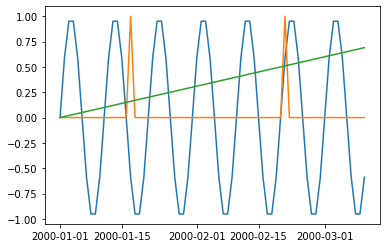

In [73]:
from u8timeseries.utils import timeseries_generation as tg

tg.periodic_timeseries(length=70).plot()
tg.us_holiday_timeseries(length=70).plot()
(tg.linear_timeseries(length=70) / 100.).plot()

## More on `TimeSeries`
### Plotting
wrapper around `pd.Series.plot()`

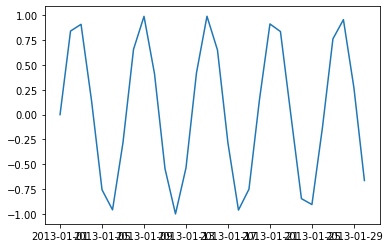

In [74]:
series.plot()

### Confidence Intervals

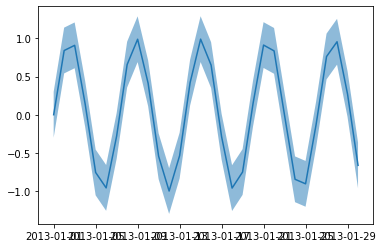

In [75]:
pdseries_low = pd.Series(np.sin(range(30)) - 0.3, index=pd.date_range('20130101', '20130130'))
pdseries_up = pd.Series(np.sin(range(30)) + 0.3, index=pd.date_range('20130101', '20130130'))

series_conf = TimeSeries(pdseries, pdseries_low, pdseries_up)

series_conf.plot()

### Drop, Slice, split

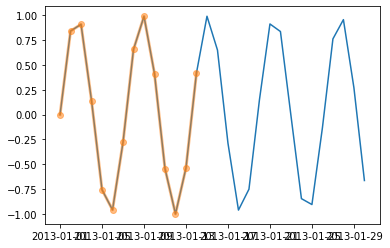

In [76]:
# Drop end:
series.plot()
beginning = series.drop_after(pd.Timestamp('20130115'))
beginning.plot(marker='o', lw=3, alpha=0.5)

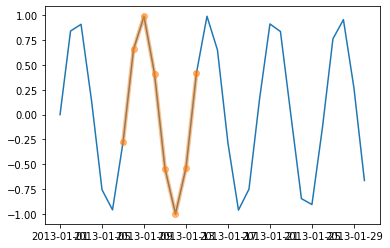

In [77]:
# Slice
subseries = series.slice(pd.Timestamp('20130107'), pd.Timestamp('20130114'))
series.plot()
subseries.plot(marker='o', lw=4, alpha=0.5)

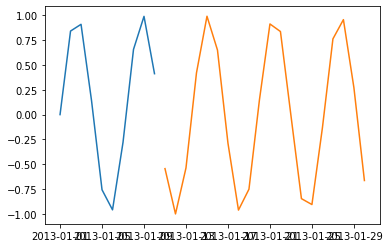

In [78]:
# Split
s1, s2 = series.split_after(pd.Timestamp('20130110'))
s1.plot()
s2.plot()

### Intersect (in time)

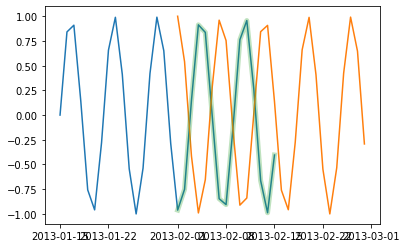

In [79]:
series1 = TimeSeries(pd.Series(np.sin(range(32)), index=pd.date_range('20130115', '20130215')))
series2 = TimeSeries(pd.Series(np.cos(range(28)), index=pd.date_range('20130201', '20130228')))

series1.plot()
series2.plot()

slice_series = series1.slice_intersect(series2)
slice_series.plot(lw=5, alpha=0.3)

`TimeSeries.intersect()` returns a slice of the time index, which can then be used for indexing:

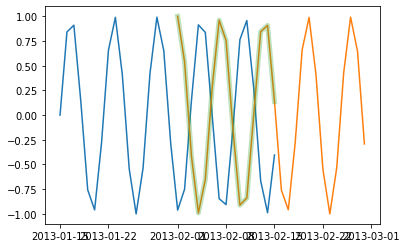

In [57]:
series1.plot()
series2.plot()

series2[series1.intersect(series2)].plot(lw=5, alpha=0.3)

# Auto-regressive Models

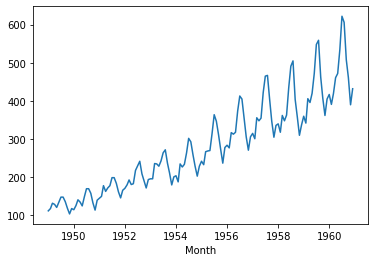

In [80]:
df = pd.read_csv('AirPassengers.csv')
series = TimeSeries.from_dataframe(df, 'Month', '#Passengers')
series.plot()

In [82]:
from u8timeseries import Theta, ExponentialSmoothing

train, val = series.split_after(pd.Timestamp('19580101'))

model_theta = Theta(theta=4)
model_ets = ExponentialSmoothing()

model_theta.fit(train)
model_ets.fit(train)

pred_val_theta = model_theta.predict(len(val))
pred_val_ets = model_ets.predict(len(val))

/Users/julien/anaconda3/envs/u8ts-test1/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



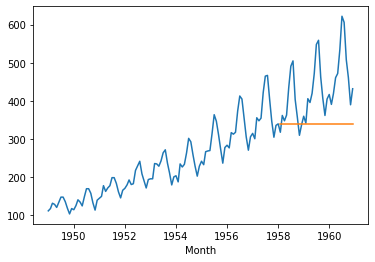

In [87]:
from u8timeseries import KthValueAgoBaseline

model_kth = KthValueAgoBaseline(k=1)
model_kth.fit(train)
pred = model_kth.predict(len(val))

series.plot()
pred.plot()

MAPE error Theta = 4.7788383704329
MAPE error ETS = 4.925019687272154


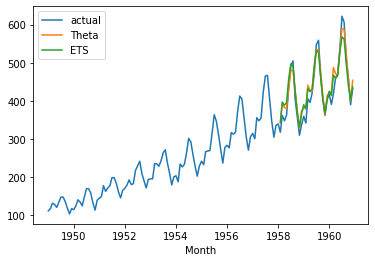

In [85]:
from u8timeseries.metrics import mape
import matplotlib.pyplot as plt

series.plot(label='actual')
pred_val_theta.plot(label='Theta')
pred_val_ets.plot(label='ETS')
plt.legend()

print('MAPE error Theta = {}'.format(mape(series.slice_intersect(pred_val_theta), pred_val_theta)))
print('MAPE error ETS = {}'.format(mape(series.slice_intersect(pred_val_ets), pred_val_ets)))

## Backtesting

In [90]:
from u8timeseries.backtesting import simulate_forecast_ar

historical_fcast = simulate_forecast_ar(series, model_ets, pd.Timestamp('19570601'), fcast_horizon_n=6, verbose=True)

/Users/julien/anaconda3/envs/u8ts-test1/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/Users/julien/anaconda3/envs/u8ts-test1/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/Users/julien/anaconda3/envs/u8ts-test1/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/Users/julien/anaconda3/envs/u8ts-test1/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/Users/julien/anaconda3/envs/u8ts-test1/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/Users/julien/anaconda3/envs/u8ts-test1/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: Conver

/Users/julien/anaconda3/envs/u8ts-test1/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



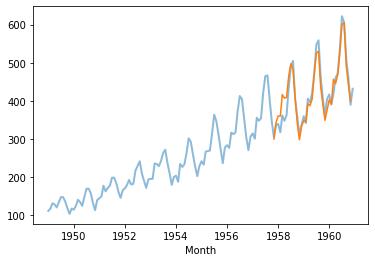

In [91]:
series.plot(lw=2, alpha=0.5)
historical_fcast.plot()

## Metrics

In [92]:
from u8timeseries.metrics import mape, mase

slice_series = series.intersect(historical_fcast)
mape(series[slice_series], historical_fcast[slice_series])

4.457909803977122